# Filtering the IFT raw segmentation results
The Ice Floe Tracker produces an image with possible sea ice floes. Often, the candidate ice floes are clearly not sea ice (e.g., clouds) or are not ice *floes*, for example being ice filaments, collections of floes smaller than the image resolution, or landfast ice. This code sets up a function to assign a probability to each identified segment, where 0 is not an ice floe and 1 is an ice floe.

The logistic regression classifier uses the shape properties and pixel brightness from the satellite imagery to assign a probability that a segmented region is an ice floe. To train the logistic regression classifier, we require a balanced set of true positives and false positives. Manually validated imagery would be ideal in some respects, however systematic differences between the way that a trained observer would draw a boundary versus the automatically detected boundaries may make a model trained on manually validated imagery ineffective. Instead, we look at the set of tracked objects, and filter out the objects that are likely artifacts.

We identify true positives as floes that satisified all of the following criteria:
    (a) tracked
    (b) traveled more than 1 pixel/day
    (c) had average speed that was physically possible (less than 1 m/s for the daily average based on the total path length)
    (d) were in a pixel with sea ice concentration > 0 outside of the landmask (to avoid including landfast ice)

We consider as false positives any non-tracked floe that was either
    (a) in a cell with sea ice concentration = 0, or
    (b) had circularity less than 0.5

## Choosing variables for the prediction



## Choosing the right threshold for the classifier


In [1]:
import os
import numpy as np
import pandas as pd
import pyproj
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from skimage.measure import regionprops_table
import sys
import warnings
import xarray as xr

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def net_displacement_pixels(floe_df):
    """Calculates net pixel displacement for trajectory"""
    delta_x = floe_df['col_pixel'].values[0] - floe_df['col_pixel'].values[-1]
    delta_y = floe_df['row_pixel'].values[0] - floe_df['row_pixel'].values[-1]
    return np.sqrt(delta_x**2 + delta_y**2)

def estimated_mean_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = (floe_df['datetime'].max() - floe_df['datetime'].min()).total_seconds()
    return np.round((np.sqrt(delta_x**2 + delta_y**2)).sum()/dt, 3)

In [5]:
# Load dataframes and scale the pixel brightness
ift_dfs = {}
for year in range(2003, 2021):
    ift_df = pd.read_csv('../data/temp/floe_properties_brightness/ift_floe_properties_with_pixel_brightness_{y}.csv'.format(y=year))
    ift_df['datetime'] = pd.to_datetime(ift_df['datetime'])
    ift_df['circularity'] = 4*np.pi*ift_df['area']/ift_df['perimeter']**2
    # Scale the pixel brightness data to 0-1
    for var in ['tc_channel0', 'tc_channel1', 'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2']:
        ift_df[var] = ift_df[var]/255
    ift_dfs[year] = ift_df.copy()

Some of the longest trajectories are associated with landfast ice in fjords that is tagged as a floe due to the dilated landmask. To remove these, we apply a path length filter, setting the minimum median pixel travel per day to 1 pixel. This removes less than 1% of tracked floes, hence we consider it a conservative filter.

CPU times: user 3.36 s, sys: 41.3 ms, total: 3.4 s
Wall time: 3.4 s


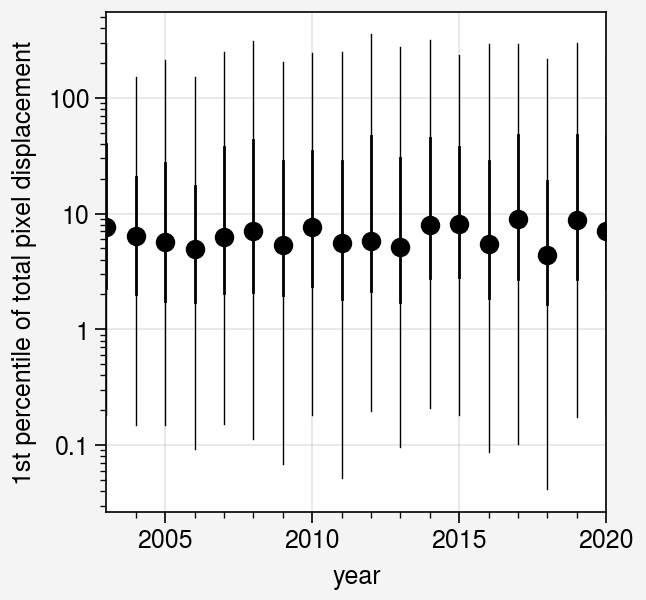

In [33]:
# Calculate the 1st percentile range for the median pixel path length for identified floes
fig, ax = pplt.subplots()
for year in ift_dfs:
    pls = ift_dfs[year].groupby('floe_id').apply(net_displacement_pixels)
    ax.plot([year, year], pls.quantile([0.01, 0.99]), lw=0.5, marker='', color='k')
    ax.plot([year, year], pls.quantile([0.25, 0.75]), lw=1, marker='', color='k')
    ax.plot([year], pls.quantile([0.5]), lw=0, marker='o', color='k')
ax.format(xlabel='year', ylabel='Net displacement (pixels)', yscale='log')

The figure shows the 1-99 percent (thin line), 25-75 percentile (thick line) and median for the distance between the first and last positions for each tracked floe. It is possible for true ice floes to be stationary. Pieces of landfast ice and artifacts from the landmask surrounding clouds are close to stationary, so for the training dataset, we are not losing many true positives by restricting the training dataset to only floes that travel at least 1 pixel.  

Similarly, we want to avoid physically impossible drift speeds. Sea ice rarely reaches even 1 m/s, particularly when averaged over the course of a day. Setting a maximum average drift speed to 1.5 m/s removes less than 1% of the observations from the pool of true positive floe shapes. Similarly, setting the minimum average drift speed to 0.01 m/s only removes a few floes.

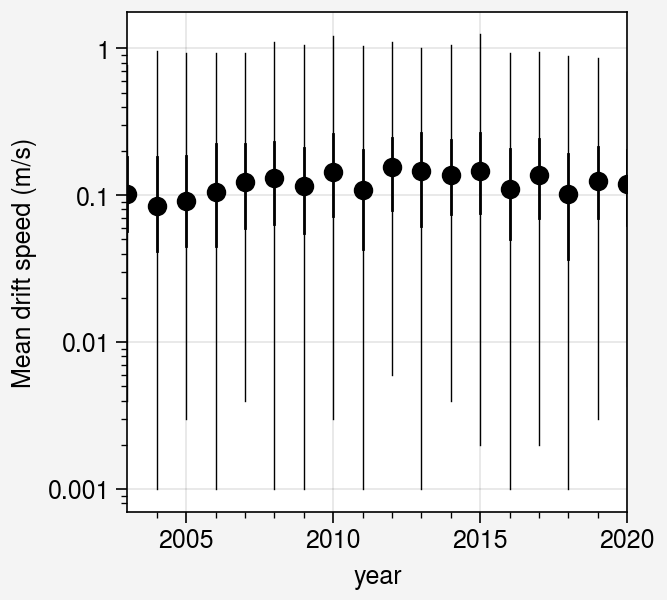

In [41]:
# Calculate the distribution of mean speeds for tracked floes
fig, ax = pplt.subplots()
for year in ift_dfs:
    mds = ift_dfs[year].groupby('floe_id').apply(estimated_mean_speed)
    ax.plot([year, year], mds.quantile([0.01, 0.99]), lw=0.5, marker='', color='k')
    ax.plot([year, year], mds.quantile([0.25, 0.75]), lw=1, marker='', color='k')
    ax.plot([year], mds.quantile([0.5]), lw=0, marker='o', color='k')
ax.format(xlabel='year', ylabel='Mean drift speed (m/s)', yscale='log')

# Classifying floes as true and false positives
This code block strings together the steps used for labeling each observations as a true positive (TP), false positive (FP), or unknown (UK). 

In [45]:
%%time
filtered_dfs = {}
for year in range(2003, 2021):
    ift_df = ift_dfs[year].copy()
    
    # Drop too-small floes (really only for 2020 since the others already filtered)
    ift_df = ift_df.loc[ift_df.area >= 300].copy() 

    ift_df['circularity'] = 4*np.pi*ift_df['area']/ift_df['perimeter']**2 

    # Scale the pixel brightness data to 0-1
    for var in ['tc_channel0', 'tc_channel1', 'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2']:
        ift_df[var] = ift_df[var]/255
    
    df_floes = ift_df.loc[ift_df.floe_id != 'unmatched']
    
    # Require a minimum of at least 1 pixel total displacement
    df_floes = df_floes.groupby('floe_id').filter(lambda x: net_displacement_pixels(x) > 1)
    
    # Average speed has to be less than 1.5 m/s and greater than 0.01 m/s
    # Calculated as path length divided by total elapsed time
    df_floes = df_floes.groupby('floe_id').filter(lambda x: (estimated_mean_speed(x) < 1.5) & \
                (estimated_mean_speed(x) > 0.01))
    
    # Remove SIC=0 and landmasked floes from TP dataset
    df_floes = df_floes.loc[(df_floes.nsidc_sic > 0) & (df_floes.nsidc_sic <= 1)]
    ift_df['classification'] = 'UK'
    ift_df.loc[ift_df.nsidc_sic == 0, 'classification'] = 'FP'
    ift_df.loc[df_floes.index, 'classification'] = 'TP'
    
    # Mark invalid data as NA. Circularity should always be less than 1 if the true
    # area/perimeter are known. I use 1.2 as an 
    # upper limit to allow for some uncertainty in the calculation.
    ift_df.loc[ift_df.circularity > 1.2, 'classification'] = 'UK'
    ift_df.loc[ift_df.tc_channel0.isnull(), 'classification'] = 'UK'

    # Mark floes with very low circularity at false positives
    # Manually-labeled floe shapes from the calibration dataset (in prep)
    # never have less than circularity=0.5, and in fact closer to 0.7 is defensible.
    # This is a strict threshold. Another option would be to sample from these,
    # preferentiably weighing it to smaller values.
    ift_df.loc[(ift_df.circularity < 0.5) & \
               (ift_df.floe_id == 'unmatched'), 'classification'] = 'FP'

    filtered_dfs[year] = ift_df.copy()

CPU times: user 49.3 s, sys: 579 ms, total: 49.9 s
Wall time: 49.8 s


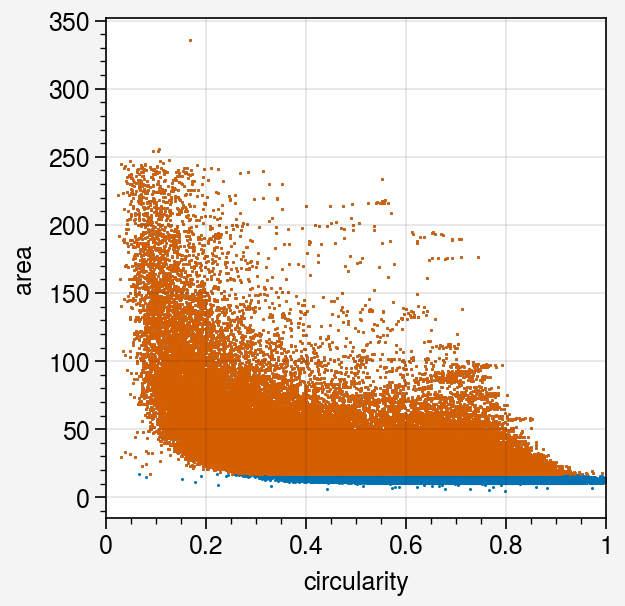

In [73]:
fig, ax = pplt.subplots()
ift_dfs[year]['circularity'] = 4*np.pi*ift_dfs[year]['area']/ift_dfs[year]['perimeter']**2 
ax.scatter(ift_dfs[year].circularity, np.sqrt(ift_dfs[year].area), marker='.', ms=1)
ax.scatter(filtered_dfs[year].circularity, np.sqrt(filtered_dfs[year].area), marker='.', ms=1)
ax.format(xlim=(0, 1))


The distributions below show that there is considerable overlap in variables between the categories. Note the log scale.

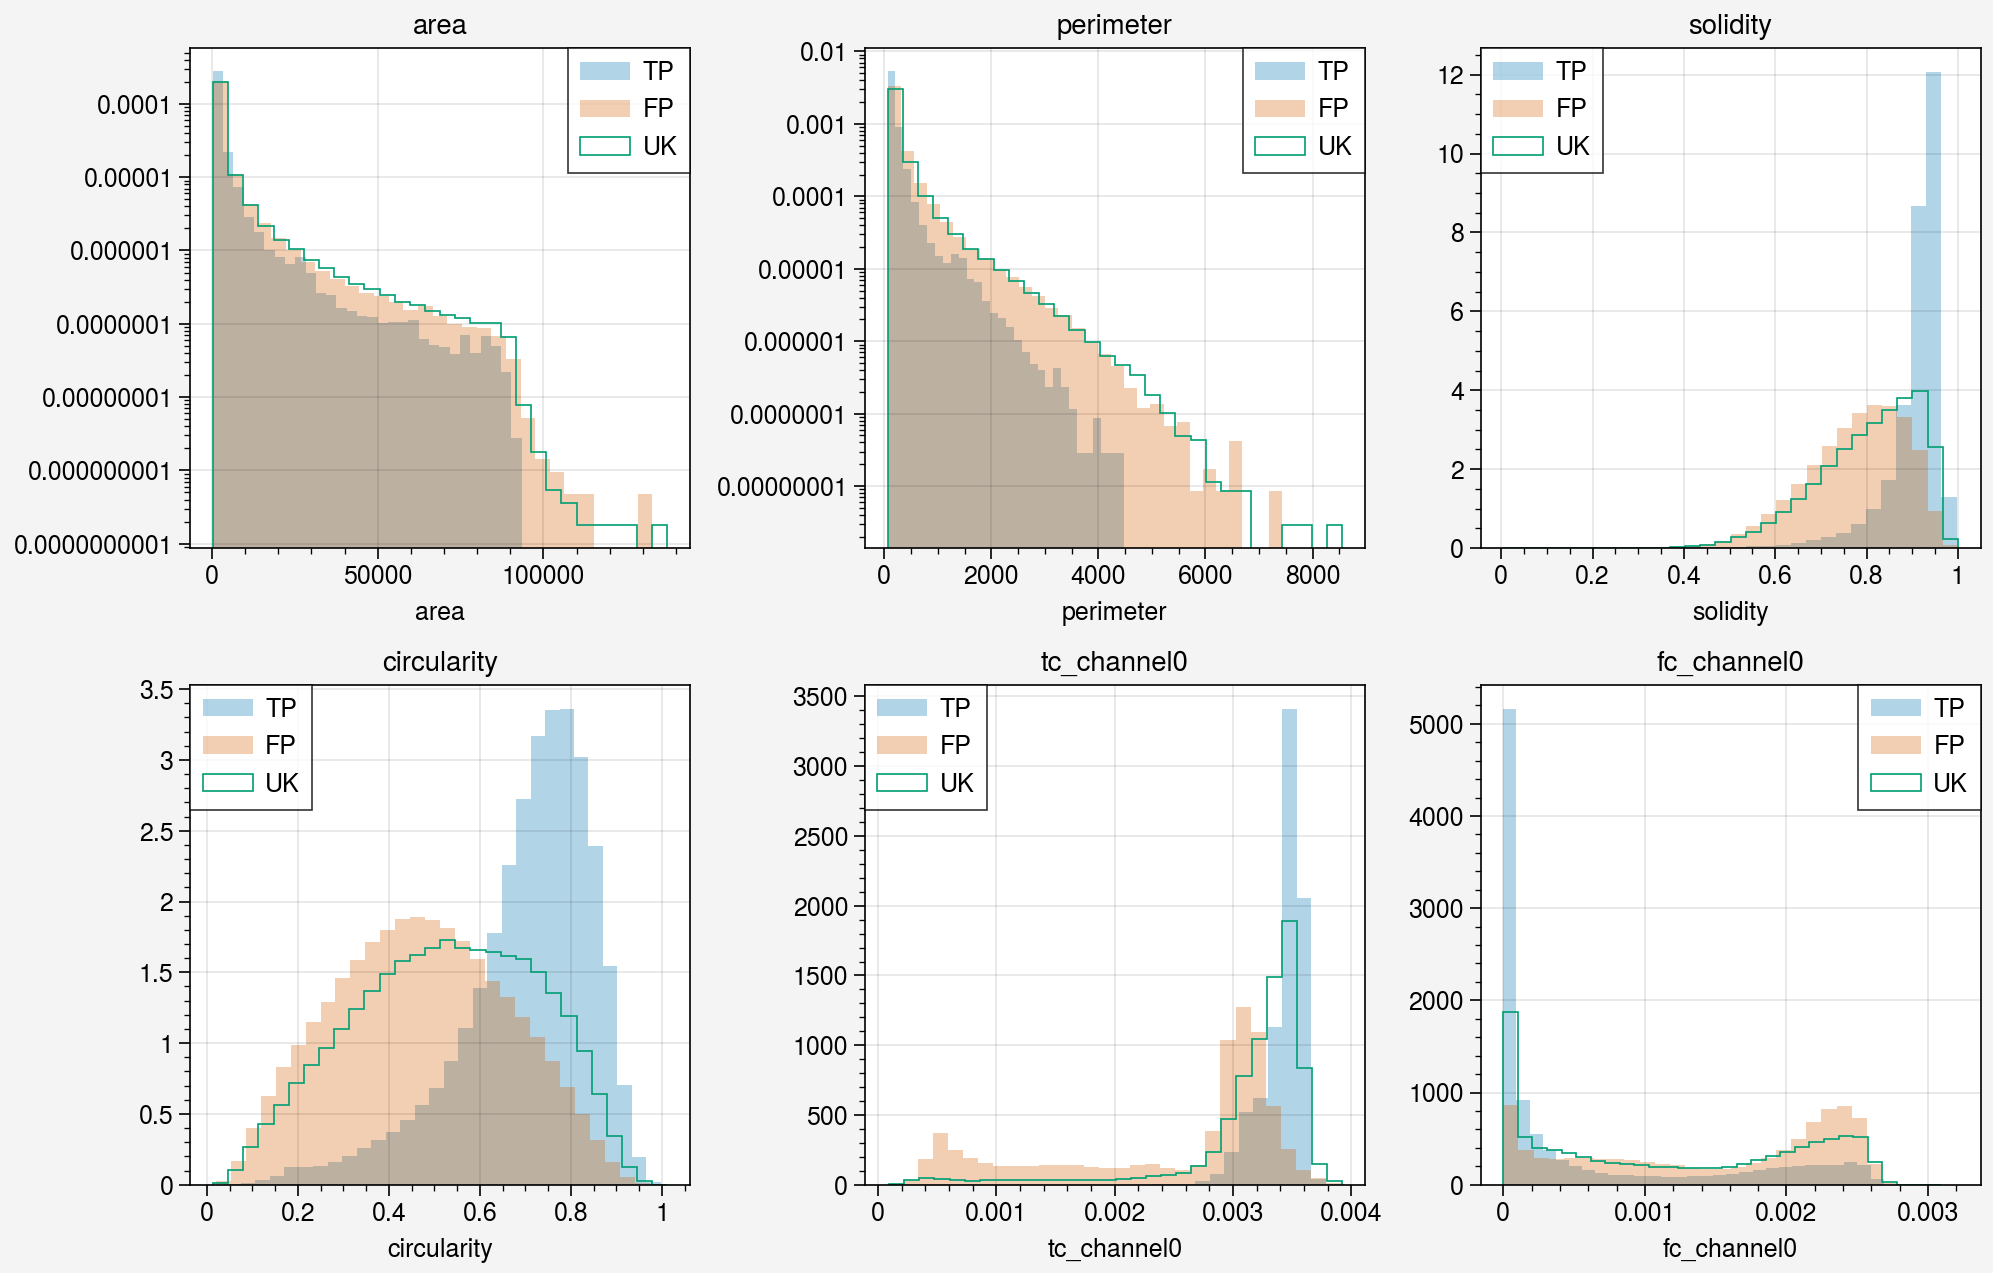

In [53]:
import proplot as pplt
all_data = pd.concat(filtered_dfs)
fig, axs = pplt.subplots(ncols=3, nrows=2, share=False)
for ax, var in zip(axs, ['area', 'perimeter', 'solidity', 'circularity', 'tc_channel0', 'fc_channel0']):
    for category in ['TP', 'FP', 'UK']:
        if category == 'UK':
            ax.hist(all_data.loc[all_data.classification == category, var],
                density=True, label=category, histtype='step',
                alpha=1, bins=30)
        else:
            ax.hist(all_data.loc[all_data.classification == category, var],
                density=True, label=category,
                alpha=0.3, bins=30)
        ax.format(title=var, yscale='linear')
        ax.legend(ncols=1)
axs[0, 0].format(yscale='log')
axs[0, 1].format(yscale='log')

# Stratified random sample
We take a stratified random sample of up to 1000 data points from each month for each category. There are more false positives than true positives. For Apr-June, there are approximately the same number of true and false positives, decreasing thereafter. 

In [31]:
data_samples = []
for year in ift_dfs:
    for month, group in ift_dfs[year].groupby(ift_dfs[year].datetime.dt.month):
        if month != 3: # Only 1 day in March in any year, so we skip it. Only use full months.
            data_samples.append(group.loc[group.classification != 'NA'].groupby('classification').apply(lambda x: x.sample(min(len(x), 1000), replace=False)))
data = pd.concat(data_samples).reset_index(drop=True)
data[['area']].groupby([data.datetime.dt.month, data.classification]).count().pivot_table(index='datetime', values='area', columns='classification')            

classification,FP,TP
datetime,,
4,18000.0,18000.0
5,18000.0,18000.0
6,18000.0,18000.0
7,18000.0,10962.0
8,18000.0,3420.0
9,18000.0,2466.0


# Variables for logistic regression
We consider two measures of the floe shape (solidity and circularity) and the 6 channels of pixel color information. As it turns out, the shape measures are highly correlated. Circularity has been used in the literature for ice segmentation before, so we use it, though the results are unlikely to be different with solidity. The color channels are also highly correlated, which makes sense with snow/ice being white. The largest contrast is between the false color channel 0 and the other color channels. So we choose one true color channel and false color channel 0.

In [8]:
data['circularity'] = 4*np.pi*data['area']/data['perimeter']**2
variables = ['solidity', 'circularity', 'tc_channel0', 'tc_channel1', 'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2']
data.loc[:, variables].corr().round(3)

,solidity,circularity,tc_channel0,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2
solidity,1.000,0.925,0.293,0.307,0.312,-0.279,0.243,0.276
circularity,0.925,1.000,0.294,0.308,0.311,-0.270,0.245,0.277
tc_channel0,0.293,0.294,1.000,0.999,0.997,0.293,0.991,0.996
tc_channel1,0.307,0.308,0.999,1.000,0.998,0.272,0.987,0.995
tc_channel2,0.312,0.311,0.997,0.998,1.000,0.263,0.983,0.991
fc_channel0,-0.279,-0.270,0.293,0.272,0.263,1.000,0.374,0.325
fc_channel1,0.243,0.245,0.991,0.987,0.983,0.374,1.000,0.996
fc_channel2,0.276,0.277,0.996,0.995,0.991,0.325,0.996,1.000


Falsecolor channels 1+2 are strongly correlated (>0.99) to each other and to both truecolor channels.
Potential to make a variable that removes the co-variability to an extent by taking a difference of channels.

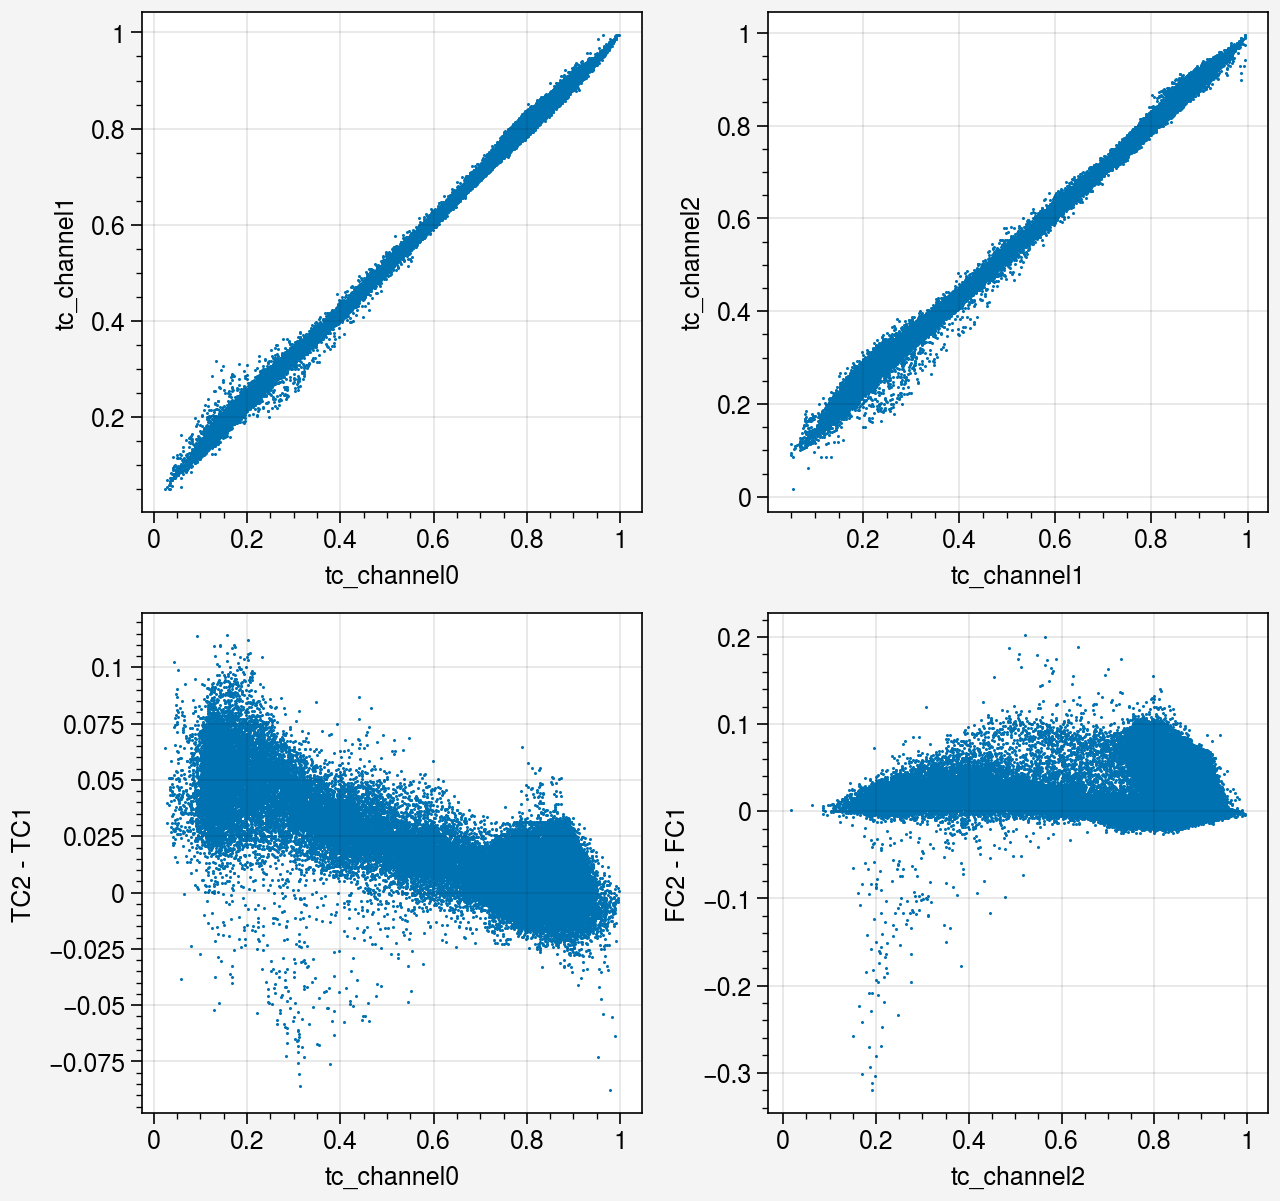

In [29]:
data['tc_diff'] = data['tc_channel2'] - data['tc_channel1']
import proplot as pplt
fig, ax = pplt.subplots(nrows=2, ncols=2, share=False)
ax[0,0].scatter(data['tc_channel0'], data['tc_channel1'], marker='.', ms=1)
ax[0,1].scatter(data['tc_channel1'], data['tc_channel2'], marker='.', ms=1)
ax[1,0].scatter(data['tc_channel0'], data['tc_channel2'] - data['tc_channel1'], marker='.', ms=1)
ax[1,1].scatter(data['tc_channel2'], data['fc_channel2'] - data['fc_channel1'], marker='.', ms=1)
ax[1, 0].format(ylabel='TC2 - TC1')
ax[1, 1].format(ylabel='FC2 - FC1')

In [41]:
minimal_variables = ['circularity', 'tc_channel0', 'fc_channel0']

X = data.loc[:, minimal_variables].to_numpy()
y =  (data.classification == 'TP').to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(Cs=10,
                     solver='lbfgs',
                     scoring='accuracy',
                     penalty='l2',
                     cv=25,
                     random_state=5).fit(X_train, y_train)

In [42]:
lr_model.score(X_test, y_test)

0.9377286027798098

In [43]:
probs = lr_model.predict_proba(X)
p_floe, p_notfloe = probs[:,0], probs[:, 1]

In [33]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, precision_recall_curve

In [34]:
y_pred = lr_model.predict(X_test)
print('F1 score: ', np.round(f1_score(y_test, y_pred), 3))
print('Recall: ', np.round(recall_score(y_test, y_pred), 3))
print('Precision: ', np.round(precision_score(y_test, y_pred), 3))

F1 score:  0.928
Recall:  0.919
Precision:  0.937


,PredTrue,PredFalse
True,0.59,0.02
False,0.03,0.36


In [37]:
lr_model.score(X_test, y_test)

0.9443428432089734

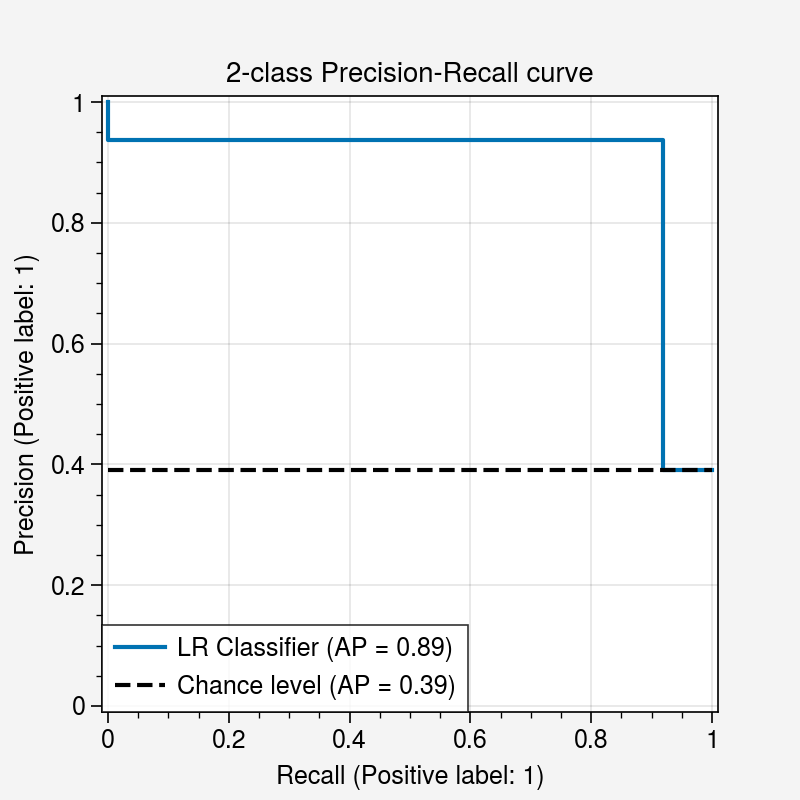

In [38]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_pred, name="LR Classifier", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [144]:
data_scaled['ProbabilityTP'] = lr_model.decision_function(data_scaled[variables].to_numpy())
data_scaled['flagged'] = ~lr_model.predict(data_scaled[variables].to_numpy())

In [47]:
for year in ift_dfs:
    probs = lr_model.predict_proba(ift_dfs[year].loc[:, minimal_variables].to_numpy())
    p_notfloe, p_floe = probs[:,0], probs[:, 1]
    ift_dfs[year]['lr_probability'] = p_floe
    ift_dfs[year]['lr_classification'] = lr_model.predict(ift_dfs[year].loc[:, minimal_variables].to_numpy())

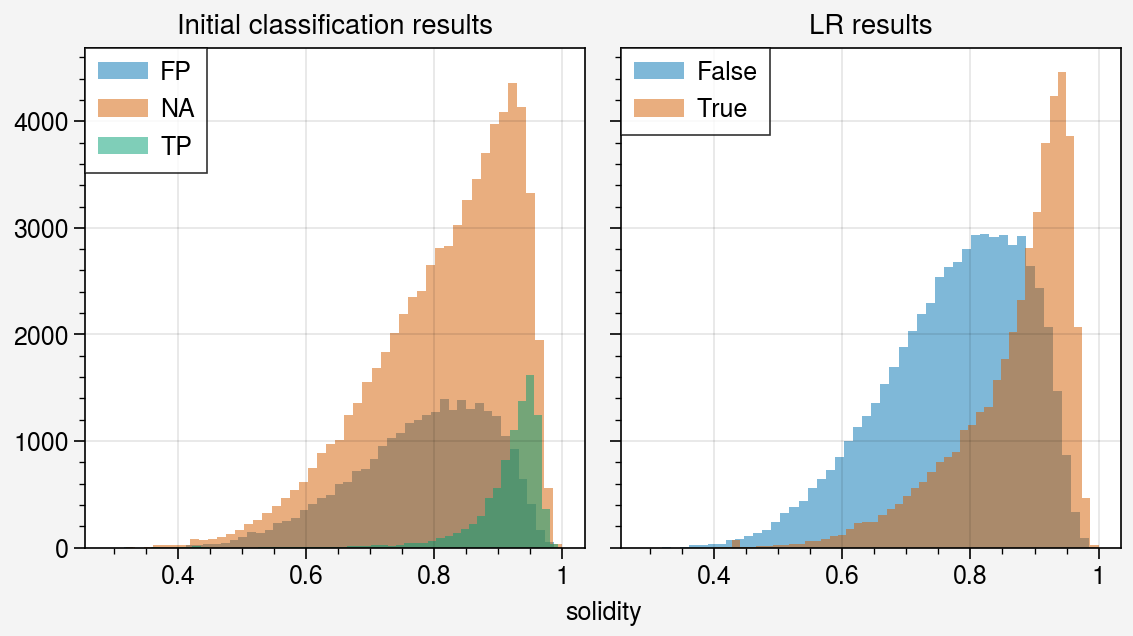

In [69]:
fig, axs = pplt.subplots(ncols=2)
year = 2010
comp_variable = 'solidity'
ax = axs[0]
ax.format(title='Initial classification results')
for name, group in ift_dfs[year].groupby('classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50)
ax.legend(ncols=1)

ax = axs[1]
ax.format(title='LR results')
for name, group in ift_dfs[year].groupby('lr_classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50)
ax.legend(ncols=1)

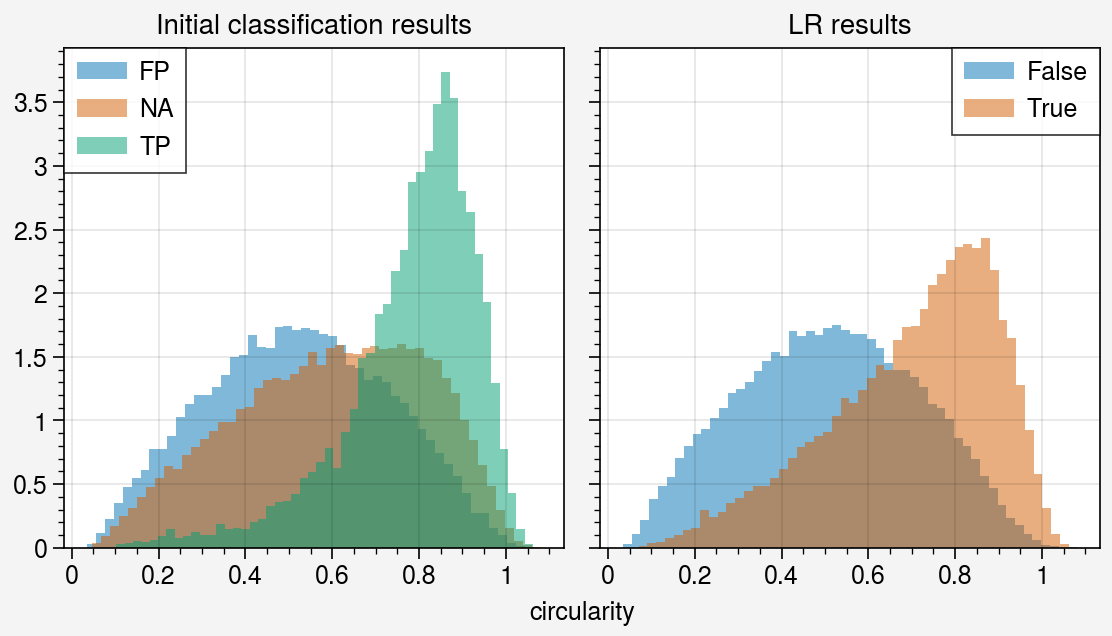

In [71]:
fig, axs = pplt.subplots(ncols=2)
year = 2010
comp_variable = 'circularity'
ax = axs[0]
ax.format(title='Initial classification results')
for name, group in ift_dfs[year].groupby('classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50, density=True)
ax.legend(ncols=1)

ax = axs[1]
ax.format(title='LR results')
for name, group in ift_dfs[year].groupby('lr_classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50, density=True)
ax.legend(ncols=1)

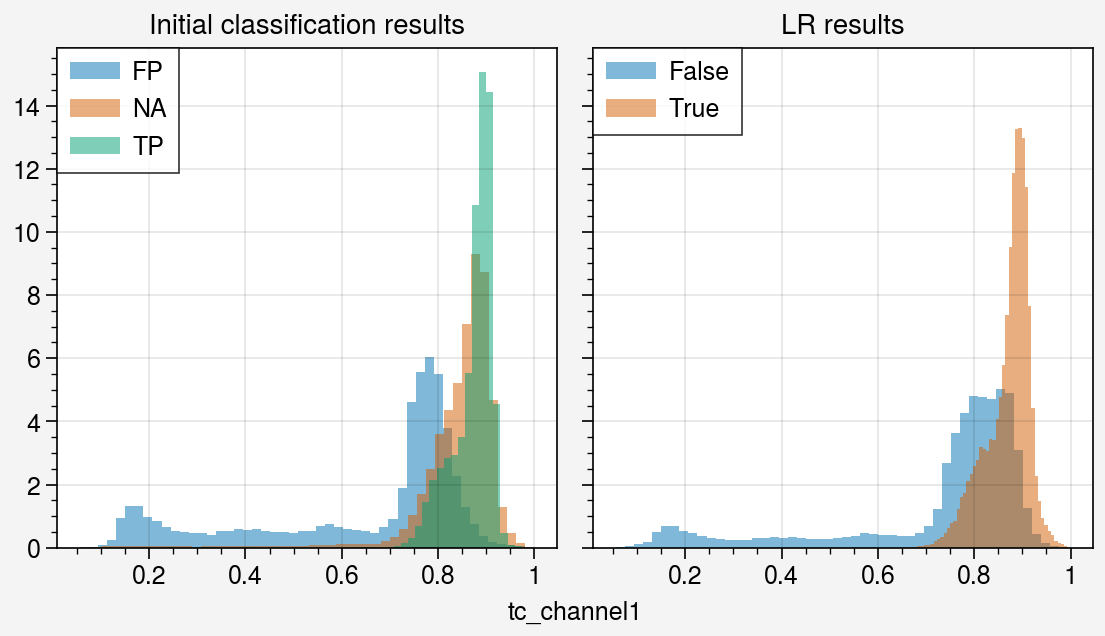

In [79]:
fig, axs = pplt.subplots(ncols=2)
year = 2010
comp_variable = 'tc_channel1'
ax = axs[0]
ax.format(title='Initial classification results')
for name, group in ift_dfs[year].groupby('classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50, density=True)
ax.legend(ncols=1)

ax = axs[1]
ax.format(title='LR results')
for name, group in ift_dfs[year].groupby('lr_classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50, density=True)
ax.legend(ncols=1)

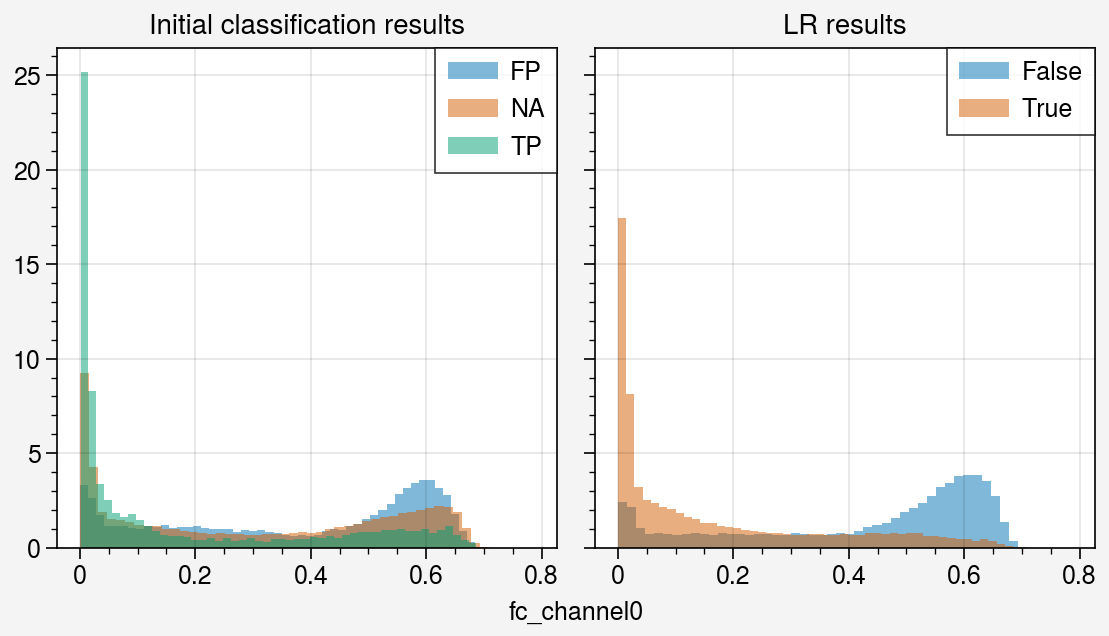

In [80]:
fig, axs = pplt.subplots(ncols=2)
year = 2010
comp_variable = 'fc_channel0'
ax = axs[0]
ax.format(title='Initial classification results')
for name, group in ift_dfs[year].groupby('classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50, density=True)
ax.legend(ncols=1)

ax = axs[1]
ax.format(title='LR results')
for name, group in ift_dfs[year].groupby('lr_classification'):
    _ = ax.hist(group[comp_variable], label=name, alpha=0.5, bins=50, density=True)
ax.legend(ncols=1)

In [76]:
n =  ift_dfs[year].loc[ift_dfs[year].classification == 'NA'].shape[0]
tp_n = ift_dfs[year].loc[ift_dfs[year].classification == 'NA', 'lr_classification'].sum()
print('Number of NAs', n)
print('Number of TPs (FPs) in the NA category', tp_n, '(', n-tp_n, ')')

Number of NAs 68024
Number of TPs (FPs) in the NA category 35966 ( 32058 )


In [85]:
for name, group in ift_dfs[year].groupby(ift_dfs[year].datetime):
    if len(group) > 100:
        break

In [90]:
group.to_csv('../../data/validation/' + 'floe_properties' + name.strftime('%Y%m%d') + group.satellite[0] + '.csv')

In [14]:
import pandas as pd
import proplot as pplt

In [63]:
df1.groupby('init_classification').count()

,Unnamed: 0,datetime,satellite,floe_id,label,longitude,latitude,x_stere,y_stere,col_pixel,...,orientation_matlab,nsidc_sic,tc_channel0,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2,lr_probability,lr_classification
init_classification,,,,,,,,,,,,,,,,,,,,,
FP,29523,29523,29523,29523,29523,29523,29523,29523,29523,29523,...,29523,29523,29523,29523,29523,29523,29523,29523,29523,29523
NA,83188,83188,83188,83188,83188,83188,83188,83188,83188,83188,...,83188,83188,83188,83188,83188,83188,83188,83188,83188,83188
TP,7203,7203,7203,7203,7203,7203,7203,7203,7203,7203,...,7203,7203,7203,7203,7203,7203,7203,7203,7203,7203
